# Sparkify Project Workspace

## Introduction
It's critical for any service provider to survive if they can sense that some of their users are about to leave or cancel their service. In this project, we are provided with dataset contain logs recorded for every user-service interaction. We will talk about detail of the dataset in later section. Our mission is to build predictive models from the dataset we owned and to predict whether a specific user has intention to churn.

To achieve our goal, we apply Pyspark as the framework of our project. Pyspark is the Spark API for Python that works efficiently especially when dealing with large size data. With the help of Spark, we are able to build highly efficient and useful applications.

## Overview

Our goal is to use log dataset to build predictive model that predicts users intention to churn. In order to get best model. We would achieve it by analyzing some features from the dataset with Spark manipulation. Furthermore, we check that if the feature can separate churned and non-churned user effectively. Finally, we would use both f1_score and accuracy as metrics to evaluate our model because sometimes we would sacrifice one when trying to optimizing the other.



Well...
Let's start the project

Blog Post of this project can be found here
https://burgercewu.medium.com/never-lose-any-one-sparkify-user-churn-prediction-challenge-using-pyspark-7ab67ac080d4
Github Repository can be found here https://github.com/BurgerWu/Sparkify-Project

**In order to run smoothly within notebook-scoped environment, we need to install some basic packages using install_pypi_package method.**

In [2]:
sc.install_pypi_package("Cython")
sc.install_pypi_package("pybind11")
sc.install_pypi_package("pythran")
sc.uninstall_package("numpy")
sc.uninstall_package("pip")
sc.install_pypi_package("pip==21.3.1")
sc.install_pypi_package("numpy==1.21.4")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("matplotlib==3.0.1")
sc.install_pypi_package("seaborn==0.9.0")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/3d/48/bbca549da0b0f636c0f161e84d30172c40aafe99552680f297da7fedf102/Cython-0.29.24-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/a8/3b/fc246e1d4c7547a7a07df830128e93c6215e9b93dcb118b2a47a70726153/pybind11-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/0a/c4/187ae2c4d39fabb8e0bb75521a00b04ba51bf37622ab799d5fc28182ea5d/pythran-0.10.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/1c/b59500a88c5c3d9d601c5ca62b9df5e0964764472faed82a182958a922c5/gast-0.5.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/58/35da89ee790598a0700ea49b2a66594140f44dec458c07e8e3d4979137fc/ply-3.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cc/4a/af3f1b3d00efd47309b7a0e28351e06453727fa55d9b3a45fd4b91031a63/beniget-0.4.1-py3-none-any.whl

Not uninstalling numpy at /usr/local/lib64/python3.7/site-pa

In [3]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, FloatType
import pyspark.sql.functions as sql_func
from pyspark.sql.functions import isnan, count, when, col, desc, udf, sort_array, asc, avg, rank, mean, first, ceil, rand, sum
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf

#import Python libraries
import math
import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
#Below lists all packages and versions we use in this notebook-scoped environment
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
11,application_1637063911317_0012,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.3)
boto (2.49.0)
click (8.0.1)
docutils (0.14)
jmespath (0.10.0)
joblib (1.0.1)
lockfile (0.11.0)
lxml (4.6.3)
mysqlclient (1.4.2)
nltk (3.6.2)
nose (1.3.4)
numpy (1.16.5)
pip (9.0.1)
py-dateutil (2.2)
pystache (0.5.4)
python-daemon (2.2.3)
python37-sagemaker-pyspark (1.4.1)
pytz (2021.1)
PyYAML (5.4.1)
regex (2021.8.3)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
tqdm (4.62.1)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [4]:
# create a Spark session with configuration
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load and Clean Dataset
Let's load the dataset and clean print out the schema of it 

In [5]:
#Load the dataset and print schema
df = spark.read.json("s3n://udacity-dsnd/sparkify/sparkify_event_data.json")
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Let's drop duplicated rows and rows with invalid userId and sessionId

In [6]:
#We drop dulicated rows 
df = df.dropDuplicates()

#We drop rows with NAN userId and sessionId
df = df.filter(df["userId"] != np.nan)
df = df.filter(df["sessionId"] != np.nan)
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

We then calculate distinct users and pages in our analysis

In [7]:
#Number of unique users (by ID)
Num_Unique_Users = df.select('userId').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Users))

#Number of different type of pages
Num_Unique_Pages = df.select('page').distinct().count()
print("There are {} distinct page types (by userID)".format(Num_Unique_Pages))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 22278 distinct users (by userID)
There are 22 distinct page types (by userID)

# Exploratory Data Analysis


## Define Churn

We define churned users as user who had been to **Cancellation Confirmation** page. We also define upgrade and downgrade event when users visited **Submit Upgrade** or **Submit Downgrade** page.

In [8]:
#Define churn as user ever been to Cancellation Confirmation page
cancel_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Cancel", cancel_churn("page"))

#Define downgrade as user ever been to Submit Downgrade page
downgrade_churn = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("Downgrade", downgrade_churn("page"))

#Define upgrade as user ever been to Submit Upgrade page
upgrade_churn = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df = df.withColumn("Upgrade", upgrade_churn("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Create User Time Span
Because some of our variable would be analyzed on a daily basis, we create a time span column that records the time length between first and last log message.

In [9]:
#Define window for time span calculation
windowSpec  = Window.partitionBy("userId")

#Create new column containing time span in days
df = df.withColumn("Time-Span", ceil((sql_func.max(col('ts')).over(windowSpec) - sql_func.min(col('ts')).over(windowSpec))/86400000))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df1 = df.limit(10000)
df1.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Cancel: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Upgrade: integer (nullable = true)
 |-- Time-Span: long (nullable = true)

In [11]:
df=df1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### General Population Exploration
Here we try to analyze all the data recorded

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

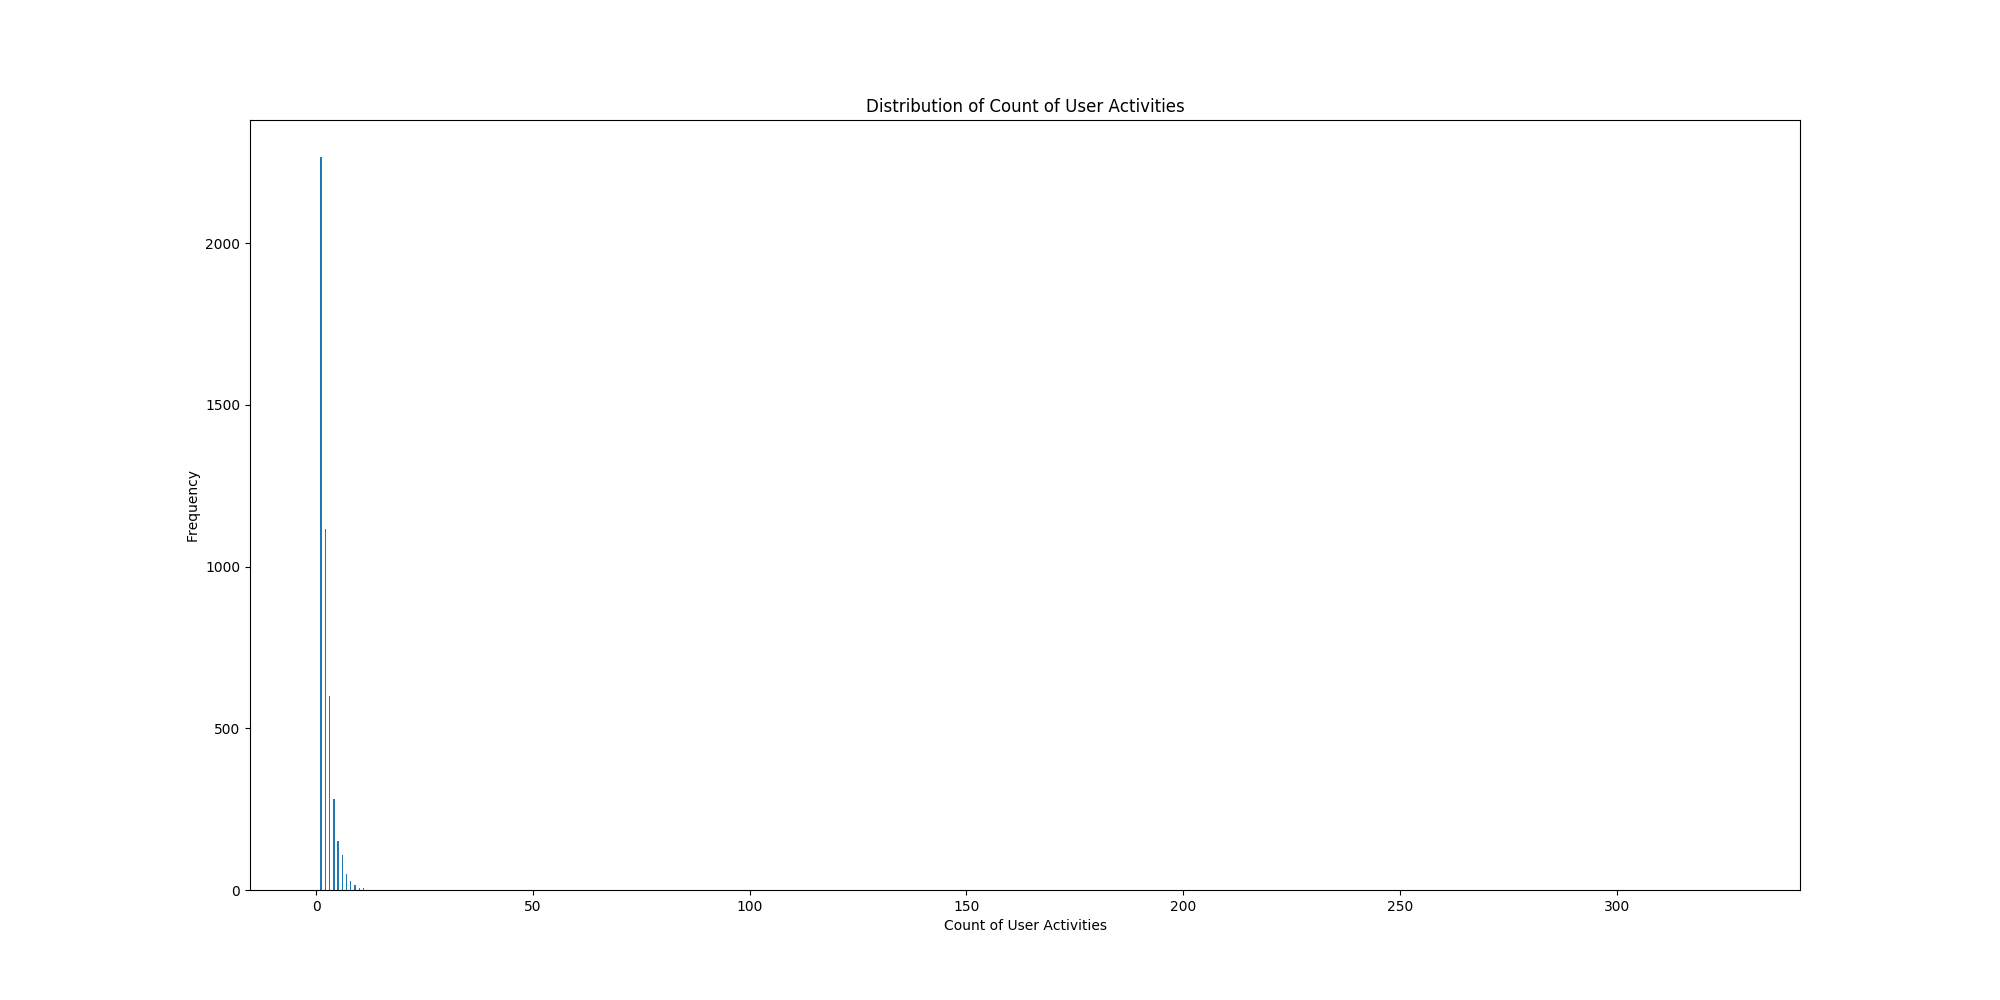

In [12]:
#Plot count of user activities recorded in our dataset
user_count = df.groupBy('userId').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.hist(user_count['count'], bins = 1000)
plt.xlabel("Count of User Activities")
plt.ylabel("Frequency")
plt.title("Distribution of Count of User Activities")
%matplot plt

The distribution of user activities count is apparently right-skewed.

### Activities by Page Type

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

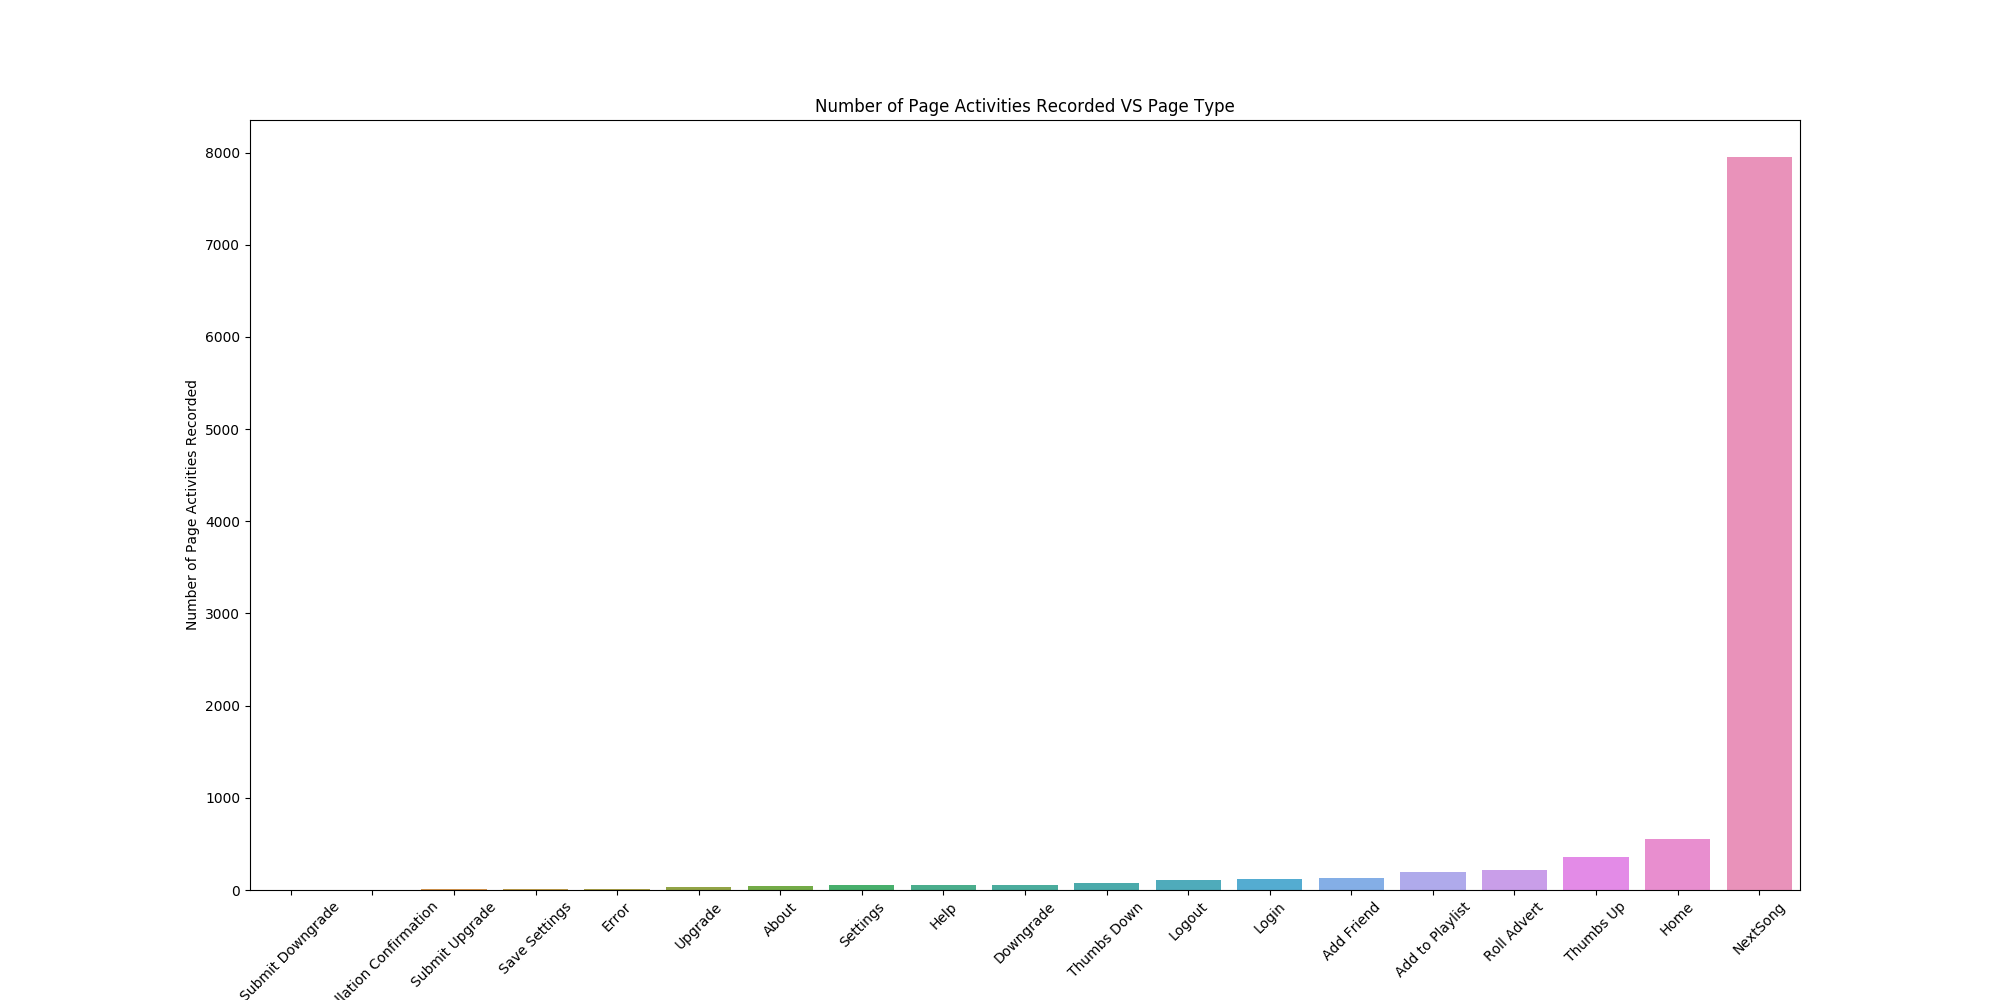

In [13]:
#Plot number of page activities recorded by page type
page_count = df.groupBy('page').count().sort("count", ascending = True).toPandas()
plt.figure(figsize = [20,10])
sb.barplot(x = 'page', y = 'count', data = page_count)
plt.xticks(rotation = 45)
plt.xlabel("Page Type")
plt.ylabel("Number of Page Activities Recorded")
plt.title("Number of Page Activities Recorded VS Page Type")
%matplot plt

The page that has most interactions with users is NextSong

### User Gender

In [11]:
#Plot number of users by gender
gender_count = df.select(['gender','userId']).distinct().groupBy('gender').count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

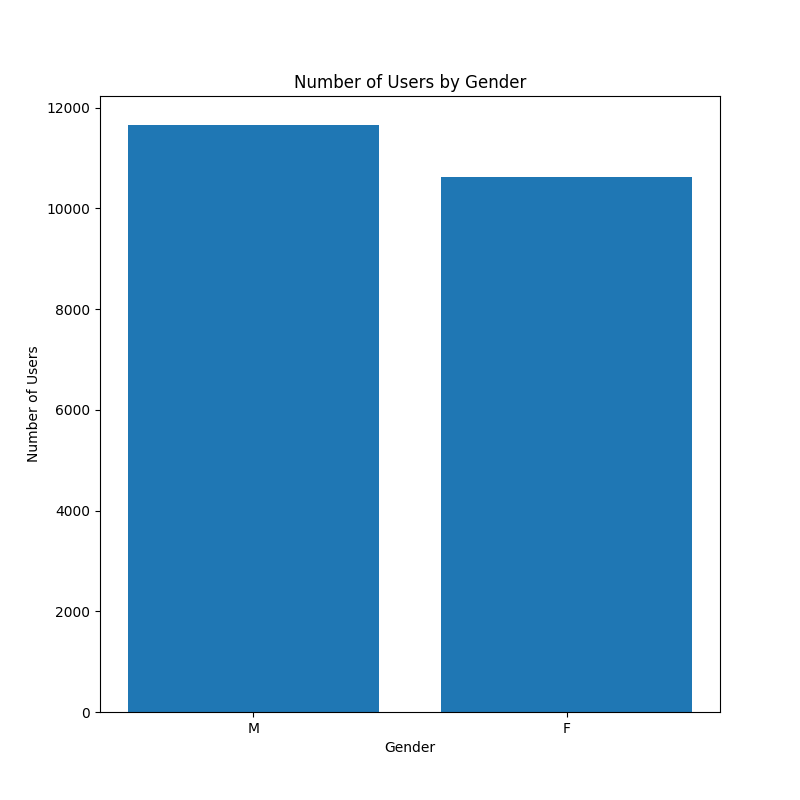

In [36]:
gender_count = gender_count[(gender_count['gender'] == 'M') | (gender_count['gender'] == 'F')]
plt.figure(figsize = [8, 8])
plt.bar(gender_count['gender'], gender_count['count'])
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users by Gender")
%matplot plt

Number of male users is slightly more than female users

### Location

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

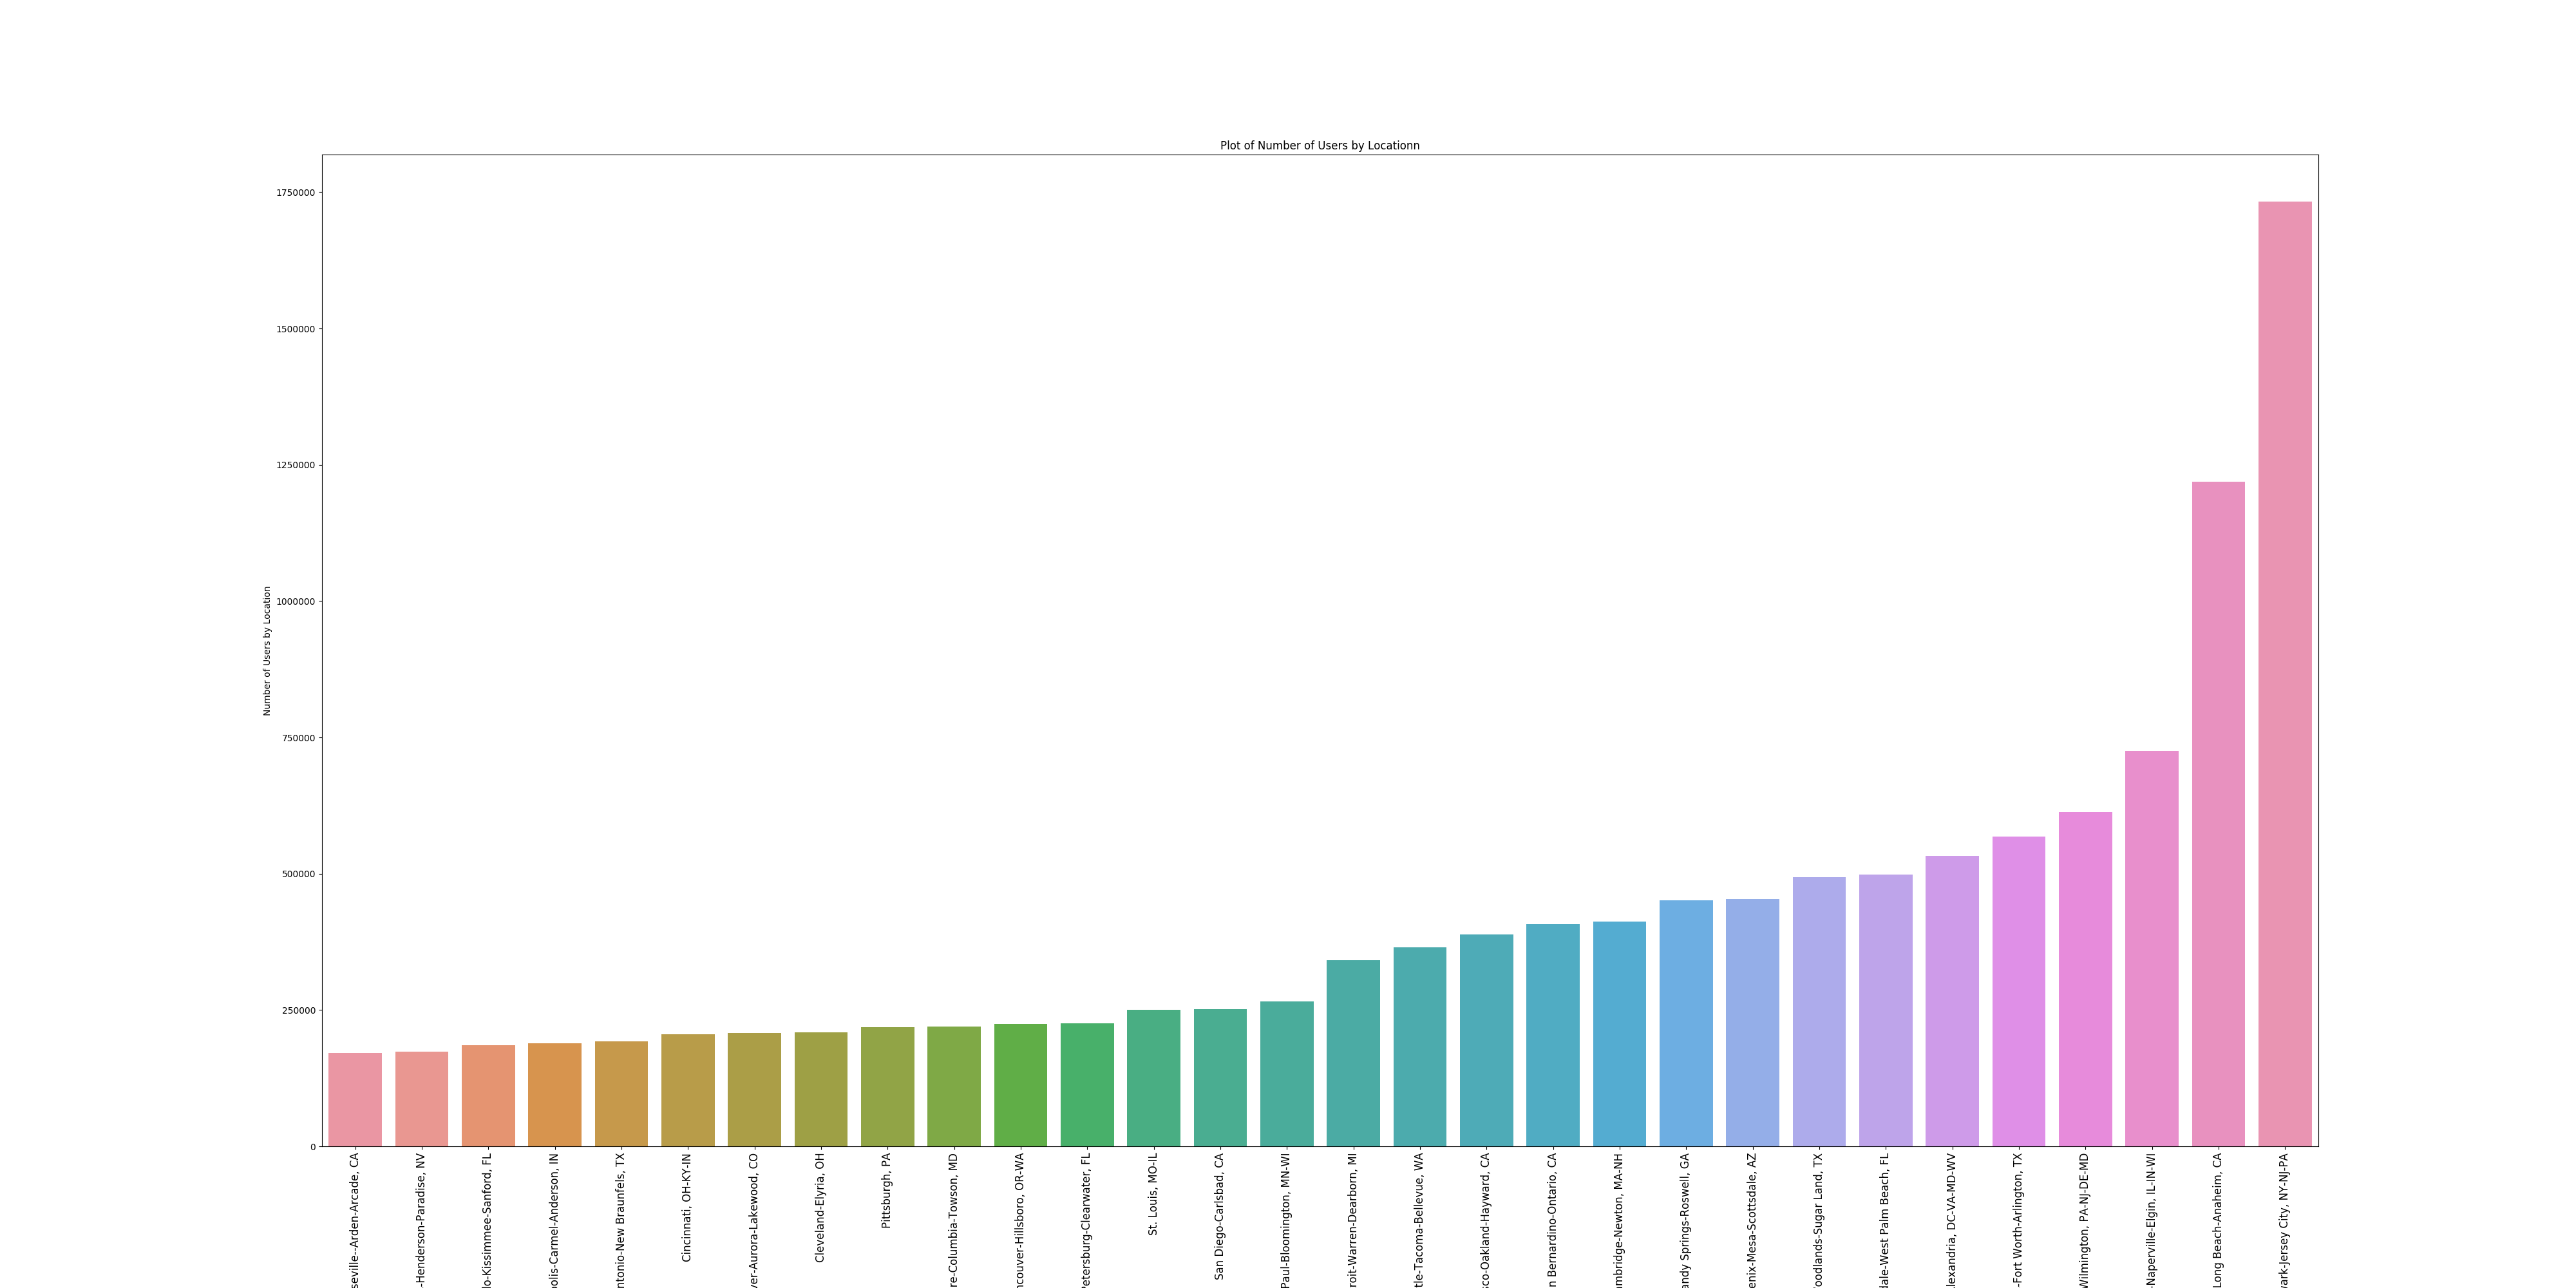

In [46]:
#Plot number of users by location
location_count = df.groupBy('location').count().orderBy("count").toPandas()
location_count = location_count.dropna()
location_count = location_count.iloc[-30:, :]

plt.figure(figsize = [40,20])
sb.barplot(x = 'location', y = 'count', data = location_count)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Location")
plt.ylabel("Number of Users by Location")
plt.title("Plot of Number of Users by Locationn")
%matplot plt

### Most Listened to Artist

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

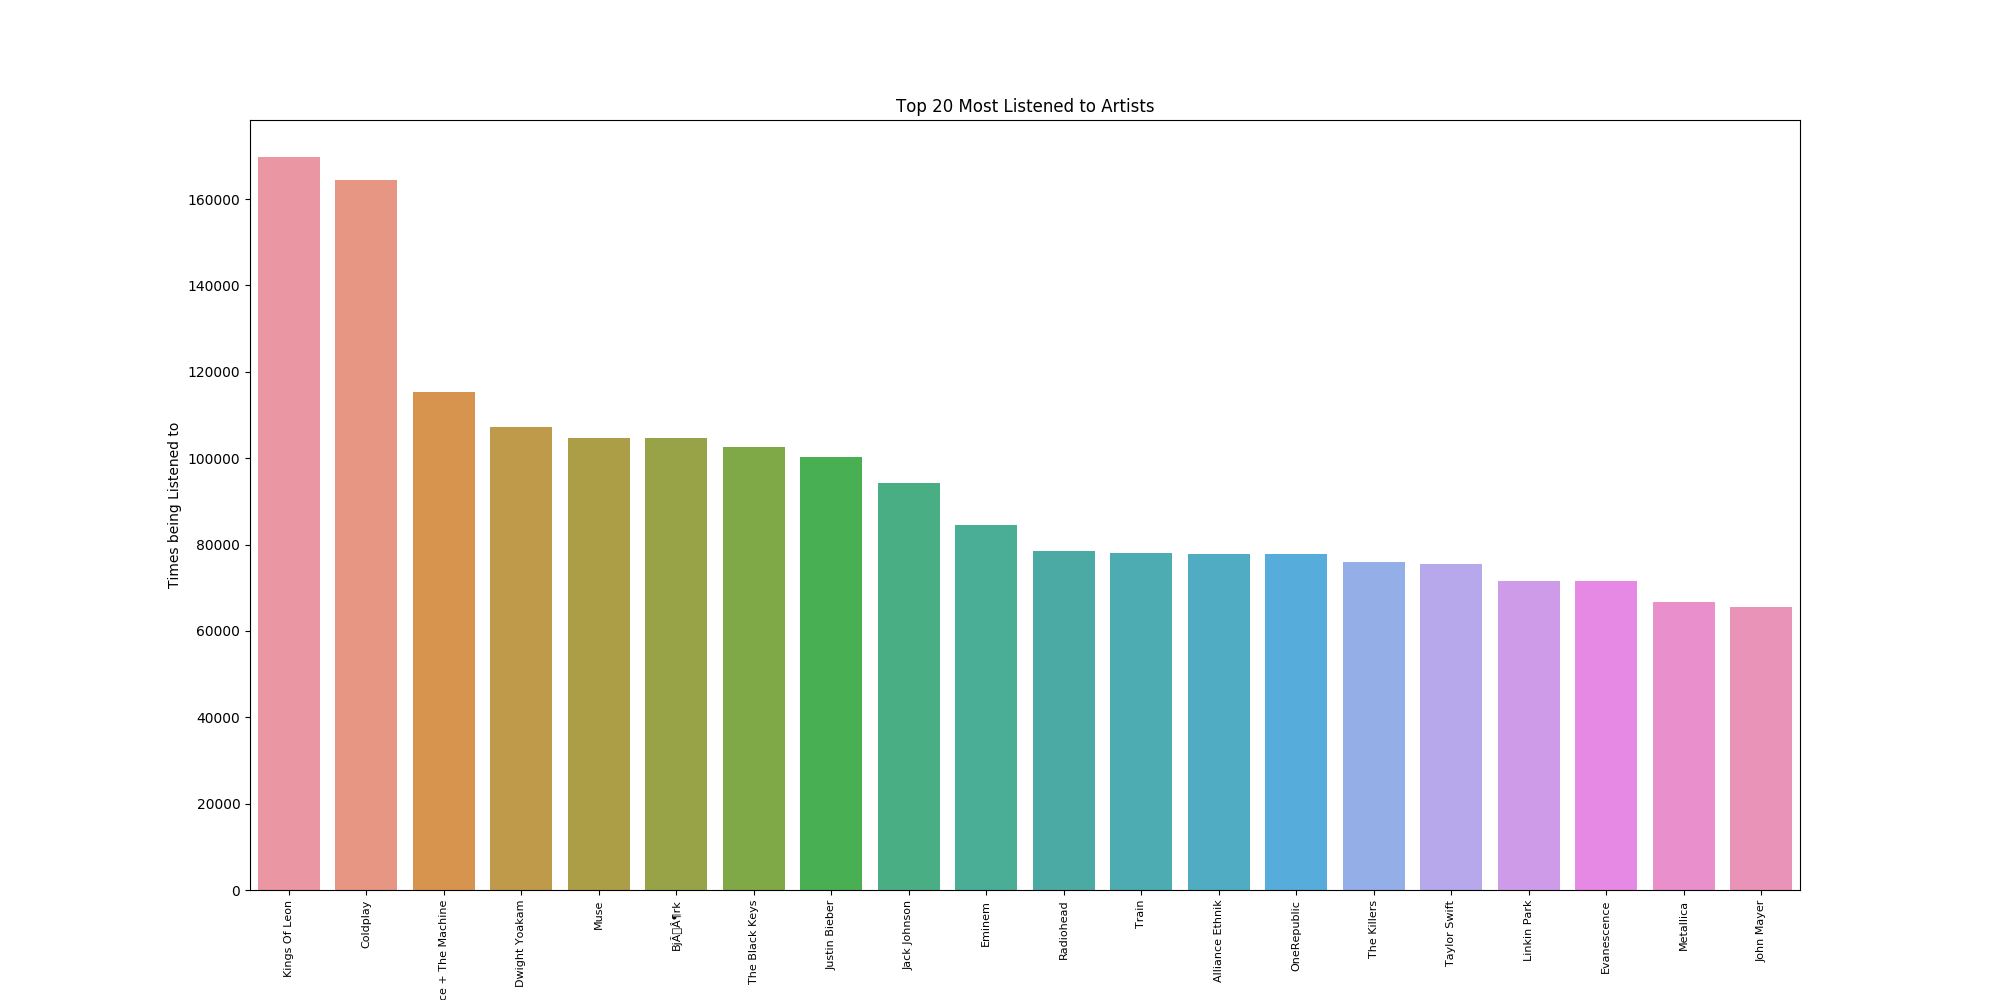

In [38]:
#Groupby artist to get most listened to artist
artist = df.groupBy('artist').count().sort('count', ascending = False).toPandas()
artist = artist.dropna()
artist = artist.iloc[:20,:]

#Plot the result of most listened to artist using barplot
plt.figure(figsize = [20,10])
sb.barplot(x = 'artist', y = 'count', data = artist)
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Artist")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Artists")
%matplot plt

### Most Listened to Songs


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

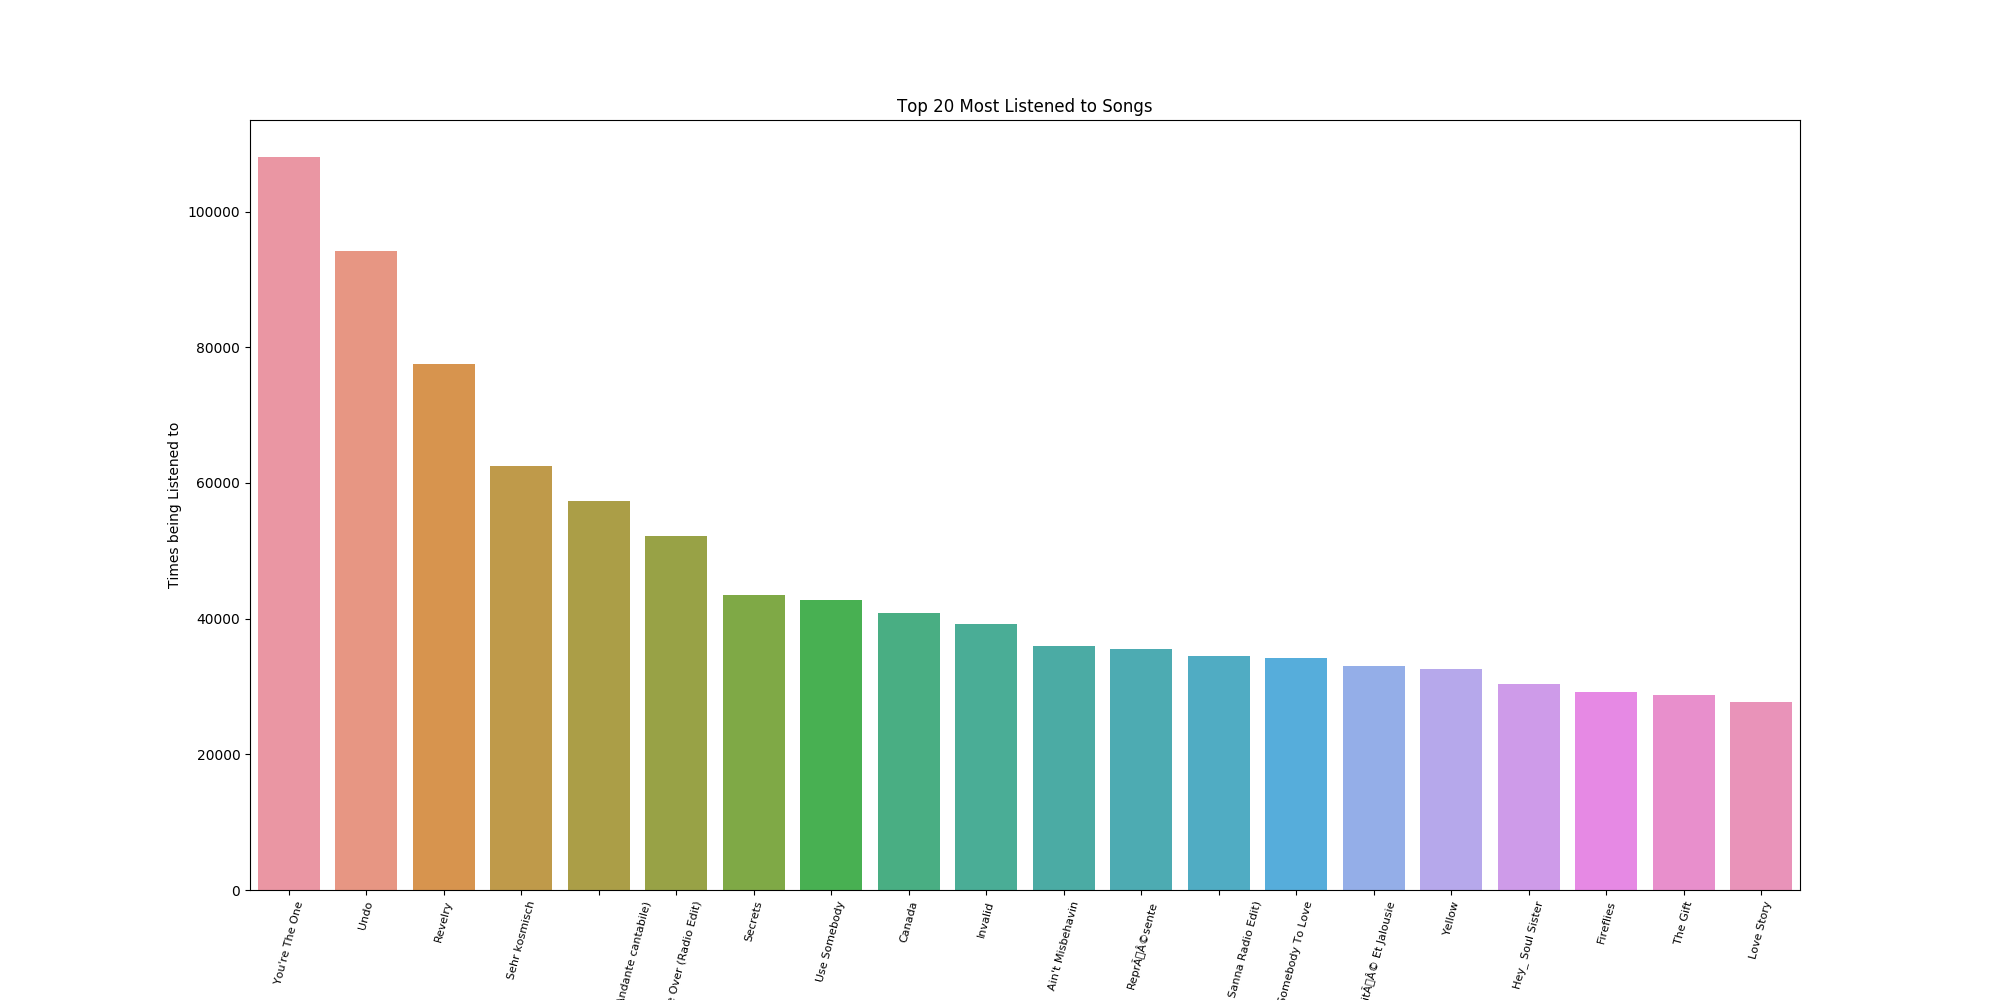

In [39]:
#We groupby songs to filter out most listened to songs
songs = df.groupBy('song').count().sort('count', ascending = False).toPandas()
songs = songs.dropna()
songs = songs.iloc[:20,:]

#We plot the barplot of 20 most listened songs
plt.figure(figsize = [20,10])
sb.barplot(x = 'song', y = 'count', data = songs)
plt.xticks(rotation = 75, fontsize=8)
plt.xlabel("Song")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Songs")
%matplot plt

### Exploration by Churned User
We first do some interesting things

In [47]:
#Find out number of churned users
num_churn_user = df.filter(df['Cancel'] == 1).groupBy('userId').count().count()

#Print our observation
print("There are {} churned (Cancellation) users, the ratio of churned users is {}".format(num_churn_user, num_churn_user/Num_Unique_Users))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 5003 churned (Cancellation) users, the ratio of churned users is 0.22457132597181076

In [48]:
#Create user table that check if  user has ever churned
churned_users_table = df.groupBy('userId').agg(sql_func.max('Cancel').alias('Churned'))
churned_users = list(churned_users_table.filter(churned_users_table['Churned'] == 1).select('userId').toPandas()['userId'])

#Define udf to transform user churn state
churn_or_not = udf(lambda x: 1 if x in churned_users else 0, IntegerType())
df = df.withColumn('Churned', churn_or_not('userId'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Times of Downgrade V.S Churned or Not
The next task is to analyze how many times users downgrade by churned users or not. 

In [49]:
#We first calculate user downgrade time and then the ratio of times per user in that churn group
user_Downgrade_Times = df.groupBy(['userId','Churned']).agg(sql_func.sum('Downgrade').alias('sum(Downgrade)')).groupBy(['Churned','sum(Downgrade)']).agg(sql_func.count('sum(Downgrade)').alias('count')).toPandas()
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

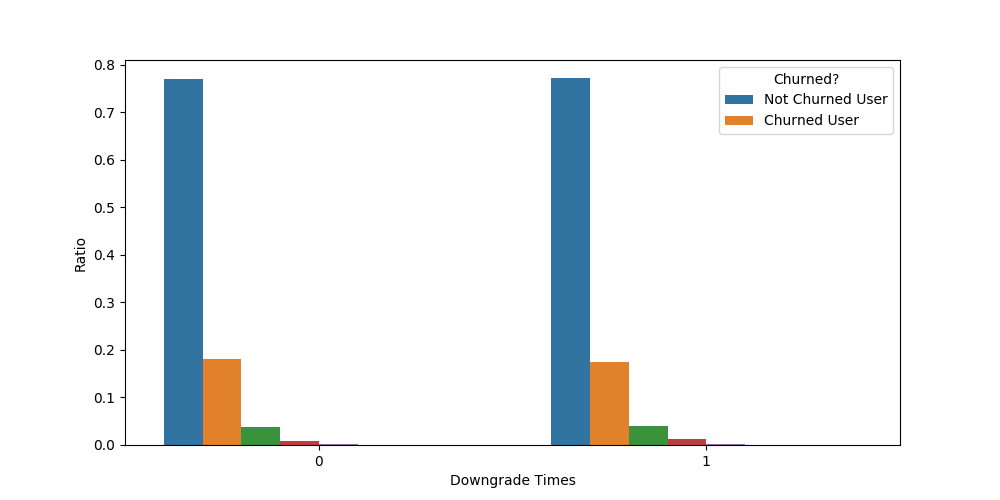

In [52]:
#Next, we plot the result using barplot
plt.figure(figsize = [10, 5])
churn_downgrade_bar = sb.barplot(x = 'Churned', y = 'count', data = user_Downgrade_Times, hue = 'sum(Downgrade)')
plt.ylabel('Ratio')
plt.xlabel('Downgrade Times')
h, l = churn_downgrade_bar.get_legend_handles_labels() 
churn_downgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')
%matplot plt

The downgrade behavior between churned and non churne user does not have sigficant difference except for some extreme values in churned user group

### Times of Upgrade V.S Churned or Not
The next task is to analyze how many times users upgrade by churned users or not. 

In [53]:
#We first calculate user upgrade times and then the ratio of times per user in that churn group
user_Upgrade_Times = df.groupBy(['userId','Churned']).sum('Upgrade').groupBy(['Churned','sum(Upgrade)']).count().toPandas()
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

#Next, we plot the result using barplot
plt.figure(figsize = [10, 5])
churn_Upgrade_bar = sb.barplot(x = 'sum(Upgrade)', y = 'count', data = user_Upgrade_Times, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Upgrade Times')
h, l = churn_Upgrade_bar.get_legend_handles_labels() 
churn_Upgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Churned  sum(Downgrade)     count
0         1               5  0.000400
1         1               2  0.039576
2         0               4  0.001389
3         1               6  0.000200
4         1               1  0.174495
5         1               4  0.001999
6         0               7  0.000058
7         0               5  0.000347
8         0               6  0.000174
9         0               2  0.037569
10        0               3  0.007699
11        0               0  0.770767
12        1               0  0.771537
13        1               3  0.011793
14        0               1  0.181997

The ratio of upgrade times dose not seem to be have significant difference between churned and non churned user.

### Final Level
In this cell, we try to figure out the final level when users decide to cancel the service

In [54]:
#Create dataframe of final level of churned user
final_level = df.orderBy(['userId','ts'],ascending = False).groupBy(['userId','Churned']).agg(first('level').alias('Final_Level'))
final_level_pd = final_level.groupBy(['Churned','Final_Level']).agg(count('Final_Level').alias("Final_Level_Count")).toPandas()
final_level_pd = final_level_pd.dropna(subset = ['Final_Level_Count'])
final_level = final_level.drop('Churned')

#Plot our result
plt.figure(figsize = [15, 7])
sb.barplot(x = final_level_pd['Final_Level'], y = final_level_pd["Final_Level_Count"], hue = final_level_pd['Churned'])
plt.title('Final_Level_Count by Churned Usr Group')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
temp_table = final_level_pd.groupby('Final_Level').sum()[['Final_Level_Count']]
temp_table.columns = ['Total Amount by Level']
final_level_pd = final_level_pd.join(temp_table, on = 'Final_Level', rsuffix='')
final_level_pd['Ratio By Level'] = final_level_pd['Final_Level_Count'] / final_level_pd['Total Amount by Level']
final_level_pd = final_level_pd[['Churned', 'Final_Level', 'Final_Level_Count', 'Ratio By Level']]
final_level_pd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Higher proportion of paid user churned

### Total Time Spent

In [ ]:
total_time = df.groupBy(['userId','Churned']).agg(sql_func.sum('length').alias('Total_Time_Spent'))
total_time_pd = total_time.toPandas()
total_time_pd = total_time_pd.dropna(subset=['Total_Time_Spent'])
total_time = total_time.drop('Churned','Time-Span')

#Plot our result to check average session length of different churned user group
plt.figure(figsize = [20,10])
sb.distplot(total_time_pd[total_time_pd['Churned'] == 0]['Total_Time_Spent'])
sb.distplot(total_time_pd[total_time_pd['Churned'] == 1]['Total_Time_Spent'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
totaltime_per_day_nonchurn = total_time_pd[total_time_pd['Churned'] == 0]['Total_Time_Spent'].mean()
totaltime_per_day_churn = total_time_pd[total_time_pd['Churned'] == 1]['Total_Time_Spent'].mean()
print("The mean value of total time spent for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(totaltime_per_day_churn,totaltime_per_day_noncchurn))

According to our statistics, it seems on average more time was spent on our service for non churned users. But the kde distribution is not so different.

### Total Songs

In [ ]:
total_songs = df.filter((df['song'].isNotNull())&(df['page'] == 'NextSong')).groupBy(['userId','Churned']).agg(count('page').alias('Total_Songs'))
total_songs_pd = total_songs.toPandas()
total_songs_pd = total_songs_pd.dropna(subset = ['Total_Songs'])
total_songs = total_songs.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(total_songs_pd[total_songs_pd['Churned'] == 0]['Total_Songs'])
sb.distplot(total_songs_pd[total_songs_pd['Churned'] == 1]['Total_Songs'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
totalsongs_per_day_nonchurn = total_songs_pd[total_songs_pd['Churned'] == 0]['Total_Songs'].mean()
totalsongs_per_day_churn = total_songs_pd[total_songs_pd['Churned'] == 1]['Total_Songs'].mean()
print("The mean value of total songs for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(totalsongs_per_day_churn,totalsongs_per_day_nonchurn))


Also, non churned users listened to more songs compared to churned users on average. But the kde distribution is not so different, either.

### Sessions per Month

In [ ]:
#Create unique songs by user group dataframe
session_month_user = df.groupBy(['userId','Churned','Time-Span','sessionId']).count().groupBy(['userId','Churned','Time-Span']).agg(count('sessionId').alias('Num_of_Sessions'))
session_month_user = session_month_user.withColumn('Sessions_per_Month', col("Num_of_Sessions")/col('Time-Span')*30)
session_month_user_pd = session_month_user.toPandas()
session_month_user_pd = session_month_user_pd.dropna(subset = ['Sessions_per_Month'])
session_month_user = session_month_user.drop('Churned',"Num_of_Sessions",'Time-Span')

#Plot our result to check average session length of different churned user group
plt.figure(figsize = [20,10])
sb.distplot(session_month_user_pd[session_month_user_pd['Churned'] == 0]['Sessions_per_Month'])
sb.distplot(session_month_user_pd[session_month_user_pd['Churned'] == 1]['Sessions_per_Month'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
session_month_user_nonchurn = session_month_user_pd[session_month_user_pd['Churned'] == 0]['Sessions_per_Month'].mean()
session_month_user_churn = session_month_user_pd[session_month_user_pd['Churned'] == 1]['Sessions_per_Month'].mean()
print("The mean value of sessions per month by churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(session_month_user_churn, session_month_user_nonchurn))


The mean value of sessions per month is much higher for churned user group and kde distribution differs a lot, too.

### Average Session Length Analysis

In [ ]:
#Apply groupby to find out averge session length of users
avg_session_length_user = df.groupBy(['userId','Churned',"sessionId"]).sum('length').groupBy(['userId','Churned']).agg(avg('sum(length)').alias('Average_Session_Length'))
avg_session_length_user_pd = avg_session_length_user.toPandas()
avg_session_length_user_pd = avg_session_length_user_pd.dropna(subset = ['Average_Session_Length'])
avg_session_length_user = avg_session_length_user.drop('Churned')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(avg_session_length_user_pd[avg_session_length_user_pd['Churned'] == 0]['Average_Session_Length'])
sb.distplot(avg_session_length_user_pd[avg_session_length_user_pd['Churned'] == 1]['Average_Session_Length'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
session_length_nonchurn = avg_session_length_user_pd[avg_session_length_user_pd['Churned'] == 0]['Average_Session_Length'].mean()
session_length_churn = avg_session_length_user_pd[avg_session_length_user_pd['Churned'] == 1]['Average_Session_Length'].mean()
print("The mean value of average session length for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(session_length_churn,session_length_nonchurn))


From the distribution of average session length, we can observe that the mean of non churned users are greater than churned users with some extreme values over 80000.

### User Device Exploration

In [ ]:
def extract_device(col):
    """
    This function extraction device from column text
    
    Input: Text content of the column
    Output: Device name
    """
    device = re.findall(r'\([a-zA-Z0-9]*',col)[0].strip()[1:]
    return device

#Define user-defined device extraction function
get_device = udf(extract_device, StringType())

#Create new column as device
df = df.withColumn('Device', get_device('userAgent'))

#Create dataframe containing information of device of churned user groups
device_user = df.groupBy(['userId','Churned']).agg(first('Device').alias('Device'))
device_user_pd = device_user.groupBy(['Churned','Device']).agg(count('Device').alias('Device_Count')).toPandas()
device_user_pd = device_user_pd.dropna(subset = ['Device'])
device_user = device_user.drop('Churned')

#Plot the result
plt.figure(figsize = [15, 7])
sb.barplot(x = device_user_pd['Churned'], y = device_user_pd['Device_Count'], hue = device_user_pd['Device'])
plt.title('Device used by user')
%matplot plt

In [ ]:
temp_table = device_user_pd.groupby('Device').sum()[['Device_Count']]
temp_table.columns = ['Total Amount by Device']
device_user_pd = device_user_pd.join(temp_table, on = 'Device', rsuffix='')
device_user_pd['Ratio By Device'] = device_user_pd['Device_Count'] / device_user_pd['Total Amount by Device']
device_user_pd = device_user_pd[['Churned', 'Device', 'Device_Count', 'Ratio By Device']]

device_user_pd.sort_values(by = 'Device')

Two major platform that our users use are Macintosh and Windows. But the ratio of churn is not different from population.

### Total Thumbs Up Given

In [ ]:
#Create unique songs by user gorup dataframe
thumbs_up_user = df.filter(df['page'] == 'Thumbs Up').groupBy(['userId','Churned']).agg(count('page').alias('Total_Thumbs_Up'))
thumbs_up_user_pd = thumbs_up_user.toPandas()
thumbs_up_user_pd = thumbs_up_user_pd.dropna(subset = ['Total_Thumbs_Up'])
thumbs_up_user = thumbs_up_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(thumbs_up_user_pd[thumbs_up_user_pd['Churned'] == 0]['Total_Thumbs_Up'])
sb.distplot(thumbs_up_user_pd[thumbs_up_user_pd['Churned'] == 1]['Total_Thumbs_Up'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
thumbs_up_nonchurn = thumbs_up_user_pd[thumbs_up_user_pd['Churned'] == 0]['Total_Thumbs_Up'].mean()
thumbs_up_churn = thumbs_up_user_pd[thumbs_up_user_pd['Churned'] == 1]['Total_Thumbs_Up'].mean()
print("The amount of thumbs up for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_up_churn, thumbs_up_nonchurn))

It seems non churned users on average give much more thumbs up than non-churned users

### Thums Ups per Day

In [ ]:
#Create unique songs by user gorup dataframe
thumbs_up_day_user = df.filter(df['page'] == 'Thumbs Up').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Up_Times'))
thumbs_up_day_user = thumbs_up_day_user.withColumn('Thumbs_Up_per_Day', col("Thumbs_Up_Times")/col('Time-Span'))
thumbs_up_day_user_pd = thumbs_up_day_user.toPandas()
thumbs_up_day_user_pd = thumbs_up_day_user_pd.dropna(subset = ['Thumbs_Up_per_Day'])
thumbs_up_day_user = thumbs_up_day_user.drop('Churned','Thumbs_Up_Times','Time-Span')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 0]['Thumbs_Up_per_Day'])
sb.distplot(thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 1]['Thumbs_Up_per_Day'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
thumbs_up_day_user_nonchurn = thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 0]['Thumbs_Up_per_Day'].mean()
thumbs_up_day_user_churn = thumbs_up_day_user_pd[thumbs_up_day_user_pd['Churned'] == 1]['Thumbs_Up_per_Day'].mean()
print("The mean value of thumbs up per day by churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_up_day_user_churn, thumbs_up_day_user_nonchurn))


The mean value of thumbs up per day is higher for churned users and with very different distribution

### Total Thumbs Down Given

In [ ]:
#Create unique songs by user gordown dataframe
thumbs_down_user = df.filter(df['page'] == 'Thumbs Down').groupBy(['userId','Churned']).agg(count('page').alias('Total_Thumbs_Down'))
thumbs_down_user_pd = thumbs_down_user.toPandas()
thumbs_down_user_pd = thumbs_down_user_pd.dropna(subset = ['Total_Thumbs_Down'])
thumbs_down_user = thumbs_down_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(thumbs_down_user_pd[thumbs_down_user_pd['Churned'] == 0]['Total_Thumbs_Down'])
sb.distplot(thumbs_down_user_pd[thumbs_down_user_pd['Churned'] == 1]['Total_Thumbs_Down'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
thumbs_down_nonchurn = thumbs_down_user_pd[thumbs_down_user_pd['Churned'] == 0]['Total_Thumbs_Down'].mean()
thumbs_down_churn = thumbs_down_user_pd[thumbs_down_user_pd['Churned'] == 1]['Total_Thumbs_Down'].mean()
print("The amount of thumbs down for churned user grodowns are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_down_churn, thumbs_down_nonchurn))

If we check thumbs down in a aggregation manner, no obvious difference is observed.

### Thumbs Down per Day

In [ ]:
#Create unique songs by user gordown dataframe
thumbs_down_day_user = df.filter(df['page'] == 'Thumbs Down').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Thumbs_Down_Times'))
thumbs_down_day_user = thumbs_down_day_user.withColumn('Thumbs_Down_per_Day', col("Thumbs_Down_Times")/col('Time-Span'))
thumbs_down_day_user_pd = thumbs_down_day_user.toPandas()
thumbs_down_day_user_pd = thumbs_down_day_user_pd.dropna(subset = ['Thumbs_Down_per_Day'])
thumbs_down_day_user = thumbs_down_day_user.drop('Churned','Thumbs_Down_Times','Time-Span')

#Plot our result to check average session length of different churned user grodown
plt.figure(figsize = [20,10])
sb.distplot(thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 0]['Thumbs_Down_per_Day'])
sb.distplot(thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 1]['Thumbs_Down_per_Day'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
thumbs_down_day_user_nonchurn = thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 0]['Thumbs_Down_per_Day'].mean()
thumbs_down_day_user_churn = thumbs_down_day_user_pd[thumbs_down_day_user_pd['Churned'] == 1]['Thumbs_Down_per_Day'].mean()
print("The mean value of thumbs down per day by churned user grodowns are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_down_day_user_churn, thumbs_down_day_user_nonchurn))


But as we check from a daily manner, the mean for churned group is much higher.

### Thumbs Up Ratio

In [ ]:
thumbs_up_ratio = churned_users_table.join(thumbs_up_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.join(thumbs_down_user, on = 'userId', how = 'left')
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio = thumbs_up_ratio.withColumn("Thumbs_Up_Ratio", col('Total_Thumbs_Up')/(col('Total_Thumbs_Down')+col('Total_Thumbs_Up')))
thumbs_up_ratio = thumbs_up_ratio.fillna(0)
thumbs_up_ratio_pd = thumbs_up_ratio.toPandas()
thumbs_up_ratio_pd = thumbs_up_ratio_pd.dropna(subset = ['Thumbs_Up_Ratio'])
thumbs_up_ratio = thumbs_up_ratio.drop('Churned', 'Total_Thumbs_Up', 'Total_Thumbs_Down')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 0]['Thumbs_Up_Ratio'])
sb.distplot(thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 1]['Thumbs_Up_Ratio'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
thumbs_up_ratio_nonchurn = thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 0]['Thumbs_Up_Ratio'].mean()
thumbs_up_ratio_churn = thumbs_up_ratio_pd[thumbs_up_ratio_pd['Churned'] == 1]['Thumbs_Up_Ratio'].mean()
print("The average thumbs up ratio for churned user grodowns are:\nChurned Users: {}\nNon-Churned Users: {}".format(thumbs_up_ratio_churn, thumbs_up_ratio_nonchurn))


As we explore the ratio of thumbs up, non-churned users seem to have higher thumbs up proportion

### Churn Gender Analysis

In [ ]:
#We create gender churn statistic by groupBy method
gender_user = df.groupBy(['userId','gender']).agg(sql_func.max('Cancel').alias("Churned"))
gender_churn_pd = gender_user.groupBy(['gender','Churned']).count().toPandas()
gender_churn_pd = gender_churn_pd.dropna(subset = ['gender'])
gender_user = gender_user.drop('Churned')

#Calculate number of male and female users
num_female = gender_churn_pd[gender_churn_pd['gender'] == 'F']['count'].sum()
num_male = gender_churn_pd[gender_churn_pd['gender'] == 'M']['count'].sum()

#Transform counts to ratio
gender_churn_pd.loc[gender_churn_pd['gender'] == 'F', 'count'] /= num_female
gender_churn_pd.loc[gender_churn_pd['gender'] == 'M', 'count'] /= num_male
gender_churn_pd.columns = ['gender', 'Churned', 'ratio']

#Plot results using barplot with hue Churned
plt.figure(figsize = [10, 5])
gender_churn_bar = sb.barplot(x = 'gender', y = 'ratio', data = gender_churn_pd, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Gender')
h, l = gender_churn_bar.get_legend_handles_labels() 
gender_churn_bar.legend(h, ['Not Churned User', 'Churned User'], title = 'Churned?', loc = 'upper right')
%matplot plt

From our result, female users have slightly higher chance to churn than male users. But all close to population behavior

### Unique Songs by Churned User Group

In [ ]:
#Create unique songs by user gorup dataframe
unique_songs_user = df.filter(df['song'].isNotNull()).dropDuplicates(subset = ['userId', 'Churned', 'song']).groupBy(['userId','Churned']).agg(count('song').alias('Unique_Songs'))
unique_songs_user_pd = unique_songs_user.toPandas()
unique_songs_user_pd = unique_songs_user_pd.dropna(subset = ['Unique_Songs'])
unique_songs_user = unique_songs_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(unique_songs_user_pd[unique_songs_user_pd['Churned'] == 0]['Unique_Songs'])
sb.distplot(unique_songs_user_pd[unique_songs_user_pd['Churned'] == 1]['Unique_Songs'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
unique_songs_nonchurn = unique_songs_user_pd[unique_songs_user_pd['Churned'] == 0]['Unique_Songs'].mean()
unique_songs_churn = unique_songs_user_pd[unique_songs_user_pd['Churned'] == 1]['Unique_Songs'].mean()
print("The mean value of unique songs for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(unique_songs_churn, unique_songs_nonchurn))


On average, non churned users have much more unique song played according to our analysis.

### Unique Artists by Churned Group

In [ ]:
#Create unique songs by user gorup dataframe
unique_artists_user = df.filter(df['artist'].isNotNull()).dropDuplicates(subset = ['userId', 'Churned', 'artist']).groupBy(['userId','Churned']).agg(count('artist').alias('Unique_Artists'))
unique_artists_user_pd = unique_artists_user.toPandas()
unique_artists_user_pd = unique_artists_user_pd.dropna(subset = ['Unique_Artists'])
unique_artists_user = unique_artists_user.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(unique_artists_user_pd[unique_artists_user_pd['Churned'] == 0]['Unique_Artists'])
sb.distplot(unique_artists_user_pd[unique_artists_user_pd['Churned'] == 1]['Unique_Artists'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
unique_artists_nonchurn = unique_artists_user_pd[unique_artists_user_pd['Churned'] == 0]['Unique_Artists'].mean()
unique_artists_churn = unique_artists_user_pd[unique_artists_user_pd['Churned'] == 1]['Unique_Artists'].mean()
print("The mean value of unique artists for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(unique_artists_churn, unique_artists_nonchurn))


Similar to unique songs, non churned users seem to have more unique artists.

### Average Item in Session by Churned User Group

In [ ]:
##Create average items in session by user group dataframe
avg_item_session = df.groupBy(['userId','Churned','sessionId']).count().groupBy(['userId','Churned']).agg(avg('count').alias('Average_Session_Item'))
avg_item_session_pd = avg_item_session.toPandas()
avg_item_session_pd = avg_item_session_pd.dropna(subset = ['Average_Session_Item'])
avg_item_session = avg_item_session.drop('Churned')

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(avg_item_session_pd[avg_item_session_pd['Churned'] == 0]['Average_Session_Item'])
sb.distplot(avg_item_session_pd[avg_item_session_pd['Churned'] == 1]['Average_Session_Item'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
avg_item_session_nonchurn = avg_item_session_pd[avg_item_session_pd['Churned'] == 0]['Average_Session_Item'].mean()
avg_item_session_churn = avg_item_session_pd[avg_item_session_pd['Churned'] == 1]['Average_Session_Item'].mean()
print("The mean value of avgerage item in session for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(avg_item_session_churn, avg_item_session_nonchurn))


On average churned users have higher amount of items in session

### Total Friends by Churned User Group

In [ ]:
#Create total friends of by user group dataframe
total_Friends = df.filter(df['page'] == 'Add Friend').groupBy(['userId','Churned']).agg(count('page').alias('Total_Friends'))
total_Friends_pd = total_Friends.toPandas()
total_Friends_pd = total_Friends_pd.dropna(subset = ['Total_Friends'])
total_Friends = total_Friends.drop('Churned')

#Plot our result
plt.figure(figsize = [20,10])
sb.distplot(total_Friends_pd[total_Friends_pd['Churned'] == 0]['Total_Friends'])
sb.distplot(total_Friends_pd[total_Friends_pd['Churned'] == 1]['Total_Friends'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
total_Friends_nonchurn = total_Friends_pd[total_Friends_pd['Churned'] == 0]['Total_Friends'].mean()
total_Friends_churn = total_Friends_pd[total_Friends_pd['Churned'] == 1]['Total_Friends'].mean()
print("The mean value of total friends for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(total_Friends_churn, total_Friends_nonchurn))


Non churned users tend to have more friends in our exploration

### Membership Duration

In [ ]:
register_user = df.orderBy(['userId','ts'], ascending = False).groupBy(['userId','Churned','registration']).agg(first('ts').alias("Last_Log_Time"))
register_user = register_user.withColumn('Membership_Duration', (col('Last_Log_Time')-col('registration'))/86400000)
register_user_pd = register_user.toPandas()
register_user_pd = register_user_pd.dropna(subset = ['Membership_Duration'])
register_user = register_user.drop("Last_Log_Time","Churned","registration")

#Plot our result 
plt.figure(figsize = [20,10])
sb.distplot(register_user_pd[register_user_pd['Churned'] == 0]['Membership_Duration'])
sb.distplot(register_user_pd[register_user_pd['Churned'] == 1]['Membership_Duration'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
member_duration_nonchurn = register_user_pd[register_user_pd['Churned'] == 0]['Membership_Duration'].mean()
member_duration_churn = register_user_pd[register_user_pd['Churned'] == 1]['Membership_Duration'].mean()
print("The mean value of membership duration for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(member_duration_churn, member_duration_nonchurn))


Non churned users tend to have longer membership duration.

### Errors per Day

In [ ]:
#Create unique songs by user group dataframe
error_day_user = df.filter(df['page'] == 'Error').groupBy(['userId','Churned','Time-Span']).agg(count('page').alias('Error_Times'))
error_day_user = error_day_user.withColumn('Error_per_Day', col("Error_Times")/col('Time-Span'))
error_day_user_pd = error_day_user.toPandas()
error_day_user_pd = error_day_user_pd.dropna(subset = ['Error_per_Day'])
error_day_user = error_day_user.drop('Churned','Error_Times','Time-Span')

#Plot our result to check average session length of different churned user group
plt.figure(figsize = [20,10])
sb.distplot(error_day_user_pd[error_day_user_pd['Churned'] == 0]['Error_per_Day'])
sb.distplot(error_day_user_pd[error_day_user_pd['Churned'] == 1]['Error_per_Day'])
plt.legend(['Not Churn User','Churned User'])
%matplot plt

#Print out textual conclusion of our result
error_day_user_nonchurn = error_day_user_pd[error_day_user_pd['Churned'] == 0]['Error_per_Day'].mean()
error_day_user_churn = error_day_user_pd[error_day_user_pd['Churned'] == 1]['Error_per_Day'].mean()
print("The mean value of error day user encountered by churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(error_day_user_churn, error_day_user_nonchurn))


Non churned users have much less errors on a daily basis.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Create userId-Churned DataFrame
This dataframe will become our seed dataframe, we will use this dataframe to merge with other results later

In [ ]:
#We use aggregation on max value of cancel column to get churned user list
User_Feature_Dataframe = df.groupBy('userId').agg(sql_func.max('Cancel').alias('Churned'))

### Final Level

In [ ]:
#Check the final state of each user (latest log record)
User_Feature_Dataframe = User_Feature_Dataframe.join(final_level, on='userId', how = 'left')

### Sessions per Month

In [ ]:
#Create sessions per month column
User_Feature_Dataframe = User_Feature_Dataframe.join(session_month_user, on='userId', how = 'left')

### Thumbs Up per Day

In [ ]:
#We create total number of thumbs up of each user
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_up_day_user, on='userId', how = 'left')

### Thumbs Down per Day

In [ ]:
#We create thumbs down per day of each user
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_down_day_user, on='userId', how = 'left')

### Thumbs Up Ratio

In [ ]:
#Join our result to the seed dataframe
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_up_ratio, on='userId', how = 'left')

### Membership Duration

In [ ]:
#Create membership duration column
User_Feature_Dataframe = User_Feature_Dataframe.join(register_user, on='userId', how = 'left')

### Errors per Day

In [ ]:
#Create errors per day column
User_Feature_Dataframe = User_Feature_Dataframe.join(error_day_user, on='userId', how = 'left')

### Fill Null Values

In [ ]:
#This cell fills all null value in our dataframe 0
User_Feature_Dataframe = User_Feature_Dataframe.fillna(0)

### Transform dummy variables

In [ ]:
def transform(column_value):
    """
    This cell check if input matches certain category
    
    Input: Row value
    Outout: 1 if the value matches category, else 0
    """
    global category
    if column_value == category:
        return 1
    else:       
        return 0

categorical_features = []    
    
#Transform categorical columns to dummy variable columns   
for col_name in ['Final_Level']:
    categories = User_Feature_Dataframe.select(col_name).distinct().collect()
    for cat in categories[1:]:    
        category = cat[col_name]
        udfs = udf(transform, IntegerType())
        User_Feature_Dataframe = User_Feature_Dataframe.withColumn(col_name + '_' + str(category), udfs(col_name))
        categorical_features.append(col_name + '_' + str(category))

#Drop categorical columns
User_Feature_Dataframe = User_Feature_Dataframe.drop('Final_Level')